In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from typing import Optional, Any, List, Tuple, Dict
import math
from dataclasses import dataclass
import time

# Seeds
np.random.seed(42)
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using", device )

Using cuda


## NumPy Indexing in Multi-Dim: Implicit Rules

Consider a tensor:
```python
x.shape == (2, 3, 4) # [seq_len, n_heads, d_head]
````

Visual layout:

```
[
  [   # first axis-0 element (token 0)
    [x000, x001, x002, x003],   # head 0
    [x010, x011, x012, x013],   # head 1
    [x020, x021, x022, x023]    # head 2
  ],

  [   # second axis-0 element (token 1)
    [x100, x101, x102, x103],   # head 0
    [x110, x111, x112, x113],   # head 1
    [x120, x121, x122, x123]    # head 2
  ]
]
```

---

### 1. Missing slices are implied

If fewer slices are provided than the number of dimensions, NumPy assumes full slices (`:`) for the remaining axes.

```python
x[:, 1]        # (2, 4), equivalent to x[:, 1, :]
```

Result:

```
[
  [x010, x011, x012, x013],   # token 0, head 1
  [x110, x111, x112, x113]    # token 1, head 1
]
```

```python
x[0]          # (3, 4), equivalent to x[0, :, :]
```

Result:

```
[
  [x000, x001, x002, x003],   # head 0
  [x010, x011, x012, x013],   # head 1
  [x020, x021, x022, x023]    # head 2
]
```

---

### 2. Integer indices remove dimensions

An integer index selects a single element along that axis and drops the dimension.

```python
x[:, :, 2]    # (2, 3), axis 2 removed
```

Result:

```
[
  [x002, x012, x022],   # token 0, all heads
  [x102, x112, x122]    # token 1, all heads
]
```

---

### 3. Slice (`:`) keeps dimensions

Using a slice preserves the axis length.

```python
x[:, 1:2, :].shape   # (2, 1, 4)
```

Result (note the extra axis of length 1):

```
[
  [
    [x010, x011, x012, x013]   # head 1 kept as axis length 1
  ],
  [
    [x110, x111, x112, x113]
  ]
]
```

---

### 4. Trailing axes can be omitted

If only the first axes are specified, NumPy assumes `:` for all remaining axes.

```python
x[0]       # (3, 4), equivalent to x[0, :, :]
```

Result (same as above for token 0):

```
[
  [x000, x001, x002, x003],
  [x010, x011, x012, x013],
  [x020, x021, x022, x023]
]
```

---

### 5. Ellipsis (`...`)

Ellipsis expands to the required number of `:` to cover missing dimensions.

```python
x[..., 2]   # (2, 3), equivalent to x[:, :, 2]
```

Result:

```
[
  [x002, x012, x022],   # token 0
  [x102, x112, x122]    # token 1
]
```

```python
x[0, ...]   # (3, 4), equivalent to x[0, :, :]
```

Result:

```
[
  [x000, x001, x002, x003],
  [x010, x011, x012, x013],
  [x020, x021, x022, x023]
]
```

# Vanilla Bidirectional Attention

In [2]:
class BidirectionalAttention:
  """Bidirectional attention without causal mask"""

  def __init__(self, d_model:int, n_heads:int):
    self.d_model = d_model
    self.n_heads = n_heads

    assert d_model % n_heads == 0, "d_model must be divisible by n_heads"


    self.d_head = d_model//n_heads

    # Weight matrices
    self.W_Q = np.random.randn(d_model, d_model) * 0.02
    self.W_K = np.random.randn(d_model, d_model) * 0.02
    self.W_V = np.random.randn(d_model, d_model) * 0.02
    self.W_O = np.random.randn(d_model, d_model) * 0.02

    print(f"Bidirectional attention: d_model={d_model}, n_heads={n_heads}, d_head={self.d_head}")

  def forward(self, x:np.ndarray ) -> Tuple[np.ndarray, np.ndarray]:
    """
    x: [seq_len, d_model]
    Returns: sequence output [seq_len, d_model], attention [seq_len, seq_len]
    """

    seq_len = x.shape[0]

    # Compute Q, K, V
    Q = x @ self.W_Q # [seq_len, d_model]
    K = x @ self.W_K # [seq_len, d_model]
    V = x @ self.W_V # [seq_len, d_model]
    print(f"\nQ,K,V shapes: {Q.shape}")

    # Reshape for the multi-head, needs [L, h, d_k]
    Q = Q.reshape(seq_len, self.n_heads, self.d_head)  #  n_heads * d_head = d_model
    K = K.reshape(seq_len, self.n_heads, self.d_head)
    V = V.reshape(seq_len, self.n_heads, self.d_head)

    # Compute attention without causal masking
    scores = np.zeros((self.n_heads, seq_len, seq_len))

    for head in range(self.n_heads):
      QK = Q[:, head] @ K[:,head].T # [L, d_k] @ [d_k, L] = [L, L]
      scores[head] = QK / np.sqrt(self.d_head) # normalization by sqrt of d_k
      print(f"Head {head}: QK^T range [{QK.min():.2f}, {QK.max():.2f}]")


    # Without Masking
    # Sofmax directly
    attention = np.exp(scores - scores.max(axis=-1, keepdims=True)) # Stability and avoid overflow for large values
    attention = attention / attention.sum(axis=-1, keepdims=True)
    print(f"Attention shape: {attention.shape}, no causal mask applied")

    # Attention to Values Matrix
    output = np.zeros((seq_len, self.d_model))
    for head in range(self.n_heads):
      head_out = attention[head] @ V[:,head] # [L, L] @ [L, d_k] = [L, d_k]
      start_idx = head * self.d_head
      end_idx = (head+1) * self.d_head
      output[:, start_idx :end_idx] = head_out

    # Output Proj
    output = output @ self.W_O
    print(f"Output shape: {output.shape}")

    return output, attention.mean(axis=0) # Average attention over heads

## Test Bidirectional vs Causal

Bidirectional attention: d_model=64, n_heads=4, d_head=16

Q,K,V shapes: (6, 64)
Head 0: QK^T range [-0.20, 0.11]
Head 1: QK^T range [-0.17, 0.37]
Head 2: QK^T range [-0.19, 0.21]
Head 3: QK^T range [-0.25, 0.25]
Attention shape: (4, 6, 6), no causal mask applied
Output shape: (6, 64)


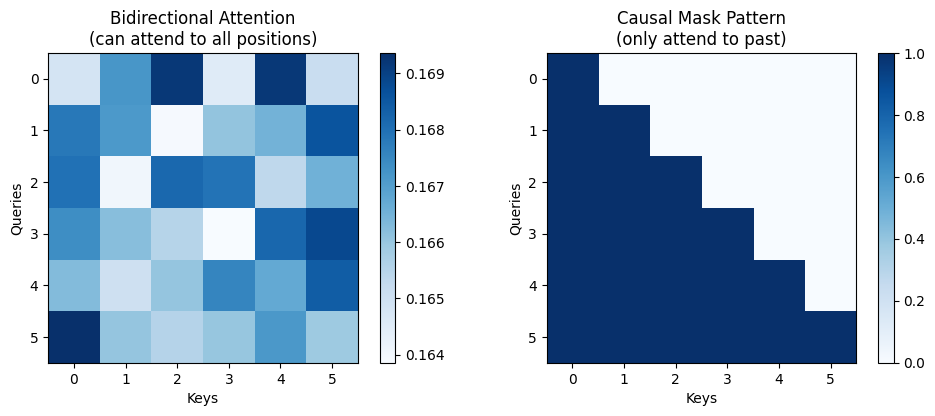


Key difference: Position 0 can attend to position 5: 0.165
In causal attention, this would be 0 (masked)


In [3]:
seq_len, d_model = 6, 64
x = np.random.randn(seq_len, d_model)

bidirectional_attn = BidirectionalAttention(d_model, n_heads=4)
output, attn_weights = bidirectional_attn.forward(x)


# Visualize bidirectional attention pattern
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(attn_weights, cmap='Blues')
plt.colorbar()
plt.title('Bidirectional Attention\n(can attend to all positions)')
plt.xlabel('Keys')
plt.ylabel('Queries')

# Show causal mask for comparison
plt.subplot(1, 2, 2)
causal_mask = np.tril(np.ones((seq_len, seq_len)))
plt.imshow(causal_mask, cmap='Blues')
plt.colorbar()
plt.title('Causal Mask Pattern\n(only attend to past)')
plt.xlabel('Keys')
plt.ylabel('Queries')
plt.tight_layout()
plt.show()

print(f"\nKey difference: Position 0 can attend to position 5: {attn_weights[0, 5]:.3f}")
print(f"In causal attention, this would be 0 (masked)")

#PyTorch Bidirectional Transformer Block

In [4]:
class BidirectionalTransformerBlock(nn.Module):
  """BERT-style transformer block without causal masking"""

  def __init__(self, d_model: int, n_heads: int, d_ff: int = None, dropout:float = 0.1):
    super().__init__()

    self.d_model = d_model
    self.n_heads = n_heads

    # Multi-head attention wihout maskin
    self.attention = nn.MultiheadAttention(self.d_model, n_heads, dropout=dropout, batch_first=True)

    # Feedforward Layer
    d_ff = d_ff or 4 * d_model # Usually FFN = 4 * hidden state

    self.ffn = nn.Sequential(
        nn.Linear(d_model, d_ff),
        nn.GELU(),    # Standard activation function in BERT, not ReLU
        nn.Dropout(dropout),
        nn.Linear(d_ff, d_model)
        )

    # Layer Norm (post-norm)
    self.ln1 = nn.LayerNorm(d_model)
    self.ln2 = nn.LayerNorm(d_model)
    self.dropout = nn.Dropout(dropout)

  def forward(self, x:torch.Tensor, padding_mask: Optional[torch.Tensor] = None):
    """
    x:  [batch, seq_len, d_model]
    padding_mask: [batch,seq_len] - True for padded positions
    """
    print(f"\nInput: {x.shape}")

    # Self attention without Causal Mask
    attn_out, attn_weights = self.attention(x, x, x,    # Q,K,V
                                            key_padding_mask = padding_mask, # Shape: [batch, seq_len]. tells the attention which tokens are padding and should not contribute to the attention output. Example: padding_mask = torch.tensor([[False, False, True, True]])  # batch=1, seq_len=4
                                            need_weights = True,  # whether the function should return the attention weights along with the output
                                            attn_mask = None # No causal mask
                                            )
    print(f"Attention output: {attn_out.shape}, weights: {attn_weights.shape}")

    # Residual connection + layer norm
    x = self.ln1(x + self.dropout(attn_out))
    print(f"After LN1: mean={x.mean():.3f}, std={x.std():.3f}")

    # Feedforward
    ffn_out = self.ffn(x)

    # Residual connection + layer norm
    x = self.ln2(x + self.dropout(ffn_out))
    print(f"After LN2: mean={x.mean():.3f}, std={x.std():.3f}")

    return x, attn_weights

## Test with mixed precision and torch.compile

In [5]:
model = BidirectionalTransformerBlock(d_model=256, n_heads=8).to(device)
print(f"Parameters: {sum(param.numel() for param in model.parameters()):,}")

# Mixed precision
from torch.cuda.amp import autocast
x = torch.randn(2,20,256).to(device)

with autocast(dtype=torch.bfloat16) if device.type == "cuda" else torch.no_grad():
  output, attn = model(x)
  print(f"\nWith bfloat16: output dtype={output.dtype}")


# Compiling
if hasattr(torch, 'compile'):
  model_compiled = torch.compile(model, mode='reduce-overhead') # Best option for small models
  print("Model compiled with torch.compile")


Parameters: 789,760

Input: torch.Size([2, 20, 256])


/tmp/ipython-input-1716660855.py:8: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=torch.bfloat16) if device.type == "cuda" else torch.no_grad():


Attention output: torch.Size([2, 20, 256]), weights: torch.Size([2, 20, 20])
After LN1: mean=-0.000, std=1.000
After LN2: mean=-0.000, std=1.000

With bfloat16: output dtype=torch.float32
Model compiled with torch.compile


# HuggingFace BERT MLM Training

In [6]:
@dataclass
class BERTPretrainingBatch:
  """Batch for BERT pretraining with MLM + NSP"""

  input_ids: torch.Tensor
  attention_mask: torch.Tensor
  token_type_ids: torch.Tensor # segment for embeddings
  mlm_labels: torch.Tensor
  nsp_labels: torch.Tensor

class BERTPretrainer(nn.Module):
  """BERT model with MLM and NSP heads"""

  def __init__(self, config):
    super().__init__()
    self.config = config

    # Token embeddings + position + segment
    self.embeddings = nn.ModuleDict({
        'token':nn.Embedding(config['vocab_size'], config['d_model']),
        'position': nn.Embedding(config['max_position'], config['d_model']),
        'segment': nn.Embedding(2, config['d_model']), # 2 segments for Next Sent Pred
    })

    # Transformer blocks
    self.blocks = nn.ModuleList([
        BidirectionalTransformerBlock(
            config['d_model'],
            config['n_heads'],
            config['d_ff']
        ) for _ in range(config['n_layers'])
    ])

    # MLM head
    self.mlm_head = nn.Sequential(
        nn.Linear(config['d_model'], config['d_model']),
        nn.GELU(),
        nn.LayerNorm(config['d_model']),
        nn.Linear(config['d_model'], config['vocab_size'])
    )

    # NSP head (binary classification)
    self.nsp_head = nn.Sequential(
        nn.Linear(config['d_model'], config['d_model']),
        nn.Tanh(),
        nn.Linear(config['d_model'], 2)
    )

    print(f"BERT Pretrainer initialized: {sum(p.numel() for p in self.parameters()):,} params")


  def forward(self, batch: BERTPretrainingBatch):

    # Combine embeddings
    x = self.embeddings['token'](batch.input_ids)
    positions = torch.arange(batch.input_ids.size(1), device=batch.input_ids.device)
    x = x + self.embeddings['position'](positions)
    x = x + self.embeddings['segment'](batch.token_type_ids)

    print(f"Embeddings: {x.shape}, norm={x.norm(dim=-1).mean():.3f}")


    # Pass through transformer blocks
    for i, block in enumerate(self.blocks):
      x, _ = block(x)
      if i == 0:
        print(f"After block {i}: {x.shape}")

    # MLM prediction for all the tokens
    mlm_logits = self.mlm_head(x) # shape [batch, seq_len, vocab_size]
    print(f"MLM logits: {mlm_logits.shape}")

    # NSP pred from [CLS] token (postion 0)
    cls_hidden = x[:, 0] # [batch, d_model]
    nsp_logits = self.nsp_head(cls_hidden) # [batch, 2]
    print(f"NSP logits: {nsp_logits.shape}")

    # Compute losses
    mlm_loss = F.cross_entropy(
        mlm_logits.view(-1, self.config['vocab_size']),
        batch.mlm_labels.view(-1),
        ignore_index = -100
    )

    nsp_loss = F.cross_entropy(nsp_logits, batch.nsp_labels)


    total_loss = mlm_loss + nsp_loss
    print(f"MLM loss: {mlm_loss:.3f}, NSP loss: {nsp_loss:.3f}, Total: {total_loss:.3f}")


    return {'loss': total_loss, 'mlm_loss': mlm_loss, 'nsp_loss': nsp_loss}



### Combined training test

In [7]:
config = {
  'vocab_size': 1000,
  'd_model': 256,
  'n_heads': 8,
  'd_ff': 1024,
  'n_layers': 2,
  'max_position': 128
}


model = BERTPretrainer(config).to(device)

# Create dummy batch
batch = BERTPretrainingBatch(
  input_ids=torch.randint(0, 1000, (4, 32)).to(device),
  attention_mask=torch.ones(4, 32).to(device),
  token_type_ids=torch.cat([torch.zeros(4, 16), torch.ones(4, 16)], dim=1).long().to(device),
  mlm_labels=torch.full((4, 32), -100).to(device),
  nsp_labels=torch.randint(0, 2, (4,)).to(device)
)

# Set some MLM labels
batch.mlm_labels[:, [5, 10, 15]] = torch.randint(0, 1000, (4, 3)).to(device)

# Forward pass with gradient accumulation
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

for step in range(2):
  print(f"\nStep {step}:")
  output = model(batch)
  loss = output['loss'] / 2  # Gradient accumulation
  loss.backward()

  if step % 2 == 1:  # Accumulate 2 steps
    optimizer.step()
    optimizer.zero_grad()
    print("Weights updated after gradient accumulation")

BERT Pretrainer initialized: 2,258,410 params

Step 0:
Embeddings: torch.Size([4, 32, 256]), norm=27.867

Input: torch.Size([4, 32, 256])
Attention output: torch.Size([4, 32, 256]), weights: torch.Size([4, 32, 32])
After LN1: mean=0.000, std=1.000
After LN2: mean=-0.000, std=1.000
After block 0: torch.Size([4, 32, 256])

Input: torch.Size([4, 32, 256])
Attention output: torch.Size([4, 32, 256]), weights: torch.Size([4, 32, 32])
After LN1: mean=0.000, std=1.000
After LN2: mean=0.000, std=1.000
MLM logits: torch.Size([4, 32, 1000])
NSP logits: torch.Size([4, 2])
MLM loss: 6.920, NSP loss: 0.638, Total: 7.557

Step 1:
Embeddings: torch.Size([4, 32, 256]), norm=27.867

Input: torch.Size([4, 32, 256])
Attention output: torch.Size([4, 32, 256]), weights: torch.Size([4, 32, 32])
After LN1: mean=-0.000, std=1.000
After LN2: mean=-0.000, std=1.000
After block 0: torch.Size([4, 32, 256])

Input: torch.Size([4, 32, 256])
Attention output: torch.Size([4, 32, 256]), weights: torch.Size([4, 32, 32])

# Contextual Embeddings and Anisotropy Computation

In [8]:
class ContextualEmbeddingExtractor:
  """Extract and analyze contexttual embeddings"""

  def __init__(self, n_layers: int, d_model: int):
    self.n_layers = n_layers
    self.d_model = d_model

  def extract_token_embeddings(self, hidden_states: List[np.ndarray], layer_indices: List[int] = None) -> np.ndarray:
    """
    Extract contextual embeddings from specified layers
    hidden_states: List of [seq_len, d_model] arrays from each layer
    """

    if layer_indices is None:
      # Defualt: using the average of the 4 last layers (common for bert), this creates a more robust representation, leveraging the hierarchical nature of the transformer representation, where diff layers capture diff semantic and linguistic properties :)
      layer_indices = list(range(max(0, len(hidden_states) -4), len(hidden_states)))

    print(f"Extracting from layers: {layer_indices}")

    # Stack selected layers
    selected = [hidden_states[i] for i in layer_indices]
    stacked = np.stack(selected, axis=0) # [n_layers, seq_len, d_model]
    print(f"Stacked shape: {stacked.shape}")


    # Average across layers
    avg_embedding = stacked.mean(axis=0) # [seq_len, d_model]
    print(f"Averaged embedding: {avg_embedding.shape}")

    return avg_embedding


  def compute_anisotropy(self, embeddings: np.ndarray) -> float:
    """
    Compute anisotropy (average cosine simiarity between random pairs)
    High anisotropy is the same as having the vectors pointing to the same direction in embeding space.
    Having isotropy instead is what we need, so that the vectors are pointing in all the directions, and not a single one (a single token).
    Anisotropy occurs bcs in all the embeddings there are always some few dimensions that dominate and for which every token will have a very high value, so they end up pointing to similar points
    The solution is to standardize the embeddings: substract the mean and divide by the stdev
    """

    n_samples = min(100, len(embeddings))
    indices= np.random.choice(len(embeddings), n_samples, replace=False)
    sampled = embeddings[indices] # extracted the sampled embeddings

    # compute pairwise cosines
    norms = np.linalg.norm(sampled, axis=1, keepdims=True)

    normalized = sampled/(norms + 1e-10) # [n_samples, d_model]
    print("normalized: \n", normalized ,"\n")


    # For normalized vectors, dot product = cosine similarity
    cosine_matrix = normalized @ normalized.T  # [n_samples, n_samples]  A symmetric matrix where each entry is the cosine similarity between two vectors (diagonal = 1.0 for self-similarity).
    print("cosine_matrix: \n", cosine_matrix ,"\n")

    # Averaging off-diagonal elements
    mask = 1 - np.eye(n_samples) # Create mask: 1s everywhere except diagonal (which has 0s). The np.eye creates identity matrix with 1s on diagonal
    print("mask: \n", mask ,"\n")


    # Element-wise multiplying the cosine_matrix with the mask, zeroing out diagonal
    # Then sum all remaining values and divide by count of 1s in mask.
    avg_cosine = (cosine_matrix * mask).sum()/mask.sum() # This measures how similar vectors are on average

    print(f"Anisotropy: {avg_cosine:.3f} (0=isotropic, 1=anisotropic)")
    return avg_cosine


  def standardize_embeddings(self, embeddings: np.ndarray) -> np.ndarray:
    """Standardize embeddings to reduce the anisotropy"""

    # Compute mean and std across al embeddings
    mu = embeddings.mean(axis = 0)  # [d_model]
    sigma = embeddings.std(axis=0) # [d_model]

    print(f"Mean norm: {np.linalg.norm(mu):.3f}")
    print(f"Std range: [{sigma.min():.3f}, {sigma.max():.3f}]")

    # Standardize: z = (x - mean) / std
    standardized = (embeddings -mu) / (sigma + 1e-10)
    print(f"After standardization: mean={standardized.mean():.3f}, std={standardized.std():.3f}")

    return standardized

### Test contextual embedding extraction

In [9]:
extractor = ContextualEmbeddingExtractor(n_layers=12, d_model=256)

# Simulate hidden states from 12 layers
seq_len = 20
hidden_states = [np.random.randn(seq_len, 256) for _ in range(12)]

# Extract embeddings
embeddings = extractor.extract_token_embeddings(hidden_states)

# Check anisotropy
anisotropy_before = extractor.compute_anisotropy(embeddings)

# Standardize to reduce anisotropy
standardized = extractor.standardize_embeddings(embeddings)


anisotropy_after = extractor.compute_anisotropy(standardized)

print(f"\nAnisotropy reduction: {anisotropy_before:.3f} -> {anisotropy_after:.3f}")

Extracting from layers: [8, 9, 10, 11]
Stacked shape: (4, 20, 256)
Averaged embedding: (20, 256)
normalized: 
 [[-0.05575485  0.02495517  0.04645206 ... -0.09427318 -0.031271
  -0.01408831]
 [ 0.08217141 -0.04819272  0.01398473 ... -0.09910592 -0.03777914
  -0.04657776]
 [ 0.1064674  -0.04734895 -0.02871198 ... -0.05495599  0.03516547
   0.02541636]
 ...
 [ 0.00423056 -0.05938702 -0.01825135 ... -0.0949535   0.0201245
   0.03475727]
 [ 0.01941091  0.00236613  0.13223387 ... -0.00723472 -0.06120021
  -0.09928411]
 [-0.05718546  0.10541353 -0.04972435 ...  0.04216606 -0.01812825
  -0.04397506]] 

cosine_matrix: 
 [[ 1.00000000e+00  8.10252549e-02 -6.35192185e-02 -1.92319935e-02
  -4.32577436e-02 -7.20383849e-03 -1.38556910e-02  5.11865665e-02
  -4.24667446e-02 -2.91384185e-02 -8.23411095e-02  1.27393204e-01
   4.65581087e-02 -5.08976764e-02  6.37838105e-02 -4.86887364e-02
  -4.68200090e-02  1.28066691e-02  2.03720400e-02  1.15023386e-01]
 [ 8.10252549e-02  1.00000000e+00  1.81056654e-02 

#  Word Sense Disambiguation with Contextual Embeddings

In [10]:
class NearestNeighborWSD:
  """Word sense disambiguation using contextual embeddigns"""

  def __init__(self):
    self.sense_embeddings = {} # sense_id -> embedding
    self.sense_examples = {}   # sense_id -> example sentences

  def create_sense_embeddings(self, labeled_examples: List[Tuple[str, str, np.ndarray]]):
    """
    Create sense embeddings from labeled examples
    labeled_examples: List of (word, sense_id, context_embedding)
    """

    sense_vectors = {}

    for word, sense_id, embedding in labeled_examples:
      if sense_id not in sense_vectors:
        sense_vectors[sense_id] = []
        self.sense_examples[sense_id] = []

      sense_vectors[sense_id].append(embedding)
      self.sense_examples[sense_id].append(word)


    # Average embedding per sense
    for sense_id, vectors in sense_vectors.items():
      self.sense_embeddings[sense_id] = np.mean(vectors, axis=0)
      print(f"Sense '{sense_id}': {len(vectors)} examples, embedding shape {self.sense_embeddings[sense_id].shape}")


  def disambiguate(self, target_embedding:np.ndarray, word:str) -> str:
    """
    Find nearest sense for the target word
    """

    best_sense = None
    best_similarity = -1

    # Compute cosine similarity with each sense
    target_norm = target_embedding / (np.linalg.norm(target_embedding) + 1e-10) # Scaling dot product with the norms to avoid the effect of those too large values


    for sense_id, sense_emb in self.sense_embeddings.items():
      sense_norm = sense_emb / (np.linalg.norm(sense_emb) + 1e-10)
      similarity = np.dot(target_norm, sense_norm)
      print(f"Similarity to '{sense_id}': {similarity:.3f}")

      if similarity > best_similarity:
        best_similarity = similarity
        best_sense = sense_id


    print(f"\nPredicted sense: '{best_sense}' (similarity: {best_similarity:.3f})")
    return best_sense

# Test Nearest Neighbor Word Sense Disambiguation


Sense 'bank_financial': 4 examples, embedding shape (256,)
Sense 'bank_river': 4 examples, embedding shape (256,)
Sense 'bank_tilt': 3 examples, embedding shape (256,)

Testing disambiguation:


financial_context:
Similarity to 'bank_financial': 0.080
Similarity to 'bank_river': -0.060
Similarity to 'bank_tilt': 0.027

Predicted sense: 'bank_financial' (similarity: 0.080)

river_context:
Similarity to 'bank_financial': 0.008
Similarity to 'bank_river': 0.257
Similarity to 'bank_tilt': 0.010

Predicted sense: 'bank_river' (similarity: 0.257)

aviation_context:
Similarity to 'bank_financial': -0.049
Similarity to 'bank_river': -0.031
Similarity to 'bank_tilt': 0.048

Predicted sense: 'bank_tilt' (similarity: 0.048)

ambiguous_context:
Similarity to 'bank_financial': -0.050
Similarity to 'bank_river': -0.024
Similarity to 'bank_tilt': -0.008

Predicted sense: 'bank_tilt' (similarity: -0.008)


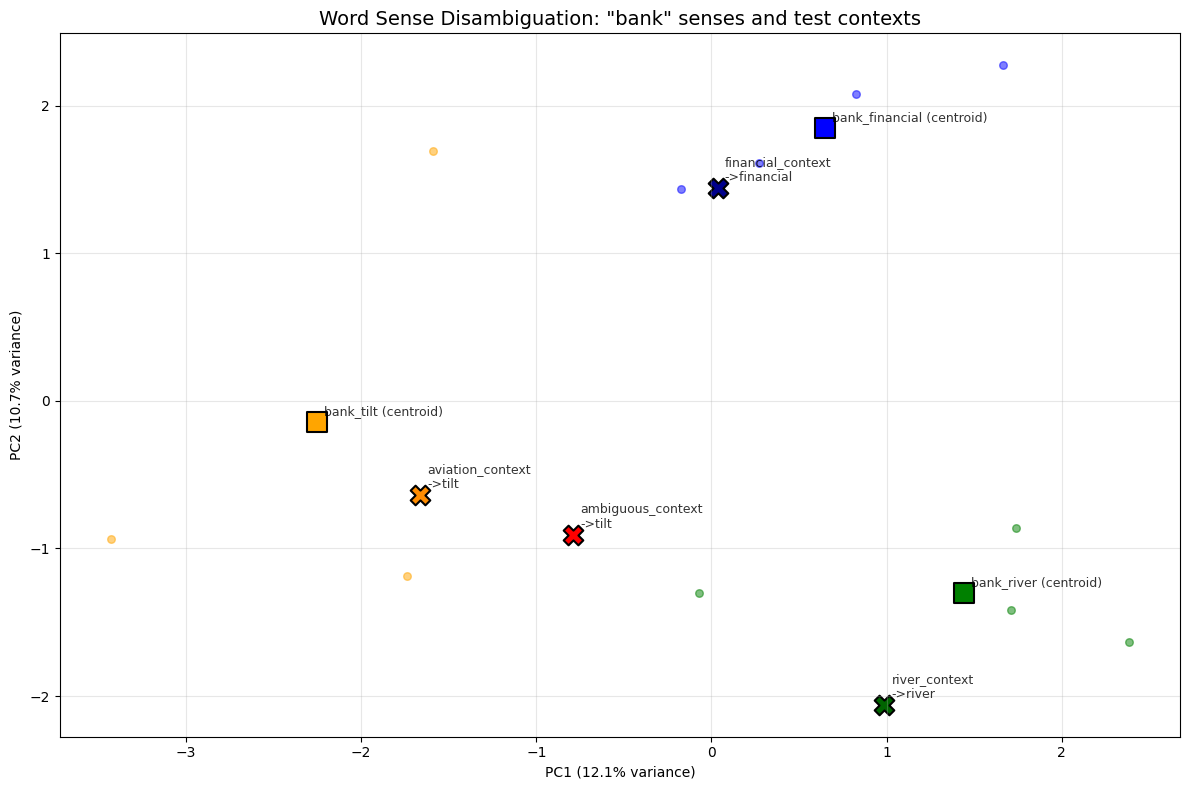

=== GRAPH ELEMENTS ===

1. SENSE CENTROIDS (large squares):
   - Blue square: 'bank_financial' centroid (average of 4 financial examples)
   - Green square: 'bank_river' centroid (average of 4 river examples)
   - Orange square: 'bank_tilt' centroid (average of 3 aviation examples)

2. TRAINING EXAMPLES (small circles, semi-transparent):
   - 4 light blue circles: individual financial bank examples
   - 4 light green circles: individual river bank examples
   - 3 light orange circles: individual tilt/aviation bank examples

3. TEST POINTS (large X markers with black edges):
   - Dark blue X: 'financial_context' - should classify as bank_financial
   - Dark green X: 'river_context' - should classify as bank_river
   - Dark orange X: 'aviation_context' - should classify as bank_tilt
   - Red X: 'ambiguous_context' - equidistant from all senses

4. VISUAL CLUSTERING:
   - PCA projects 256-dim vectors to 2D
   - Similar embeddings cluster together
   - Distance between points ≈ cosine simi

In [11]:
wsd = NearestNeighborWSD()

# Create more diverse sense embeddings for 'bank' with 3 senses
bank_examples = [
    # Financial sense cluster (more examples for better centroid)
    ("bank", "bank_financial", np.random.randn(256) * 0.3 + np.array([1.0, 0.5] + [0] * 254)),
    ("bank", "bank_financial", np.random.randn(256) * 0.3 + np.array([1.2, 0.4] + [0] * 254)),
    ("bank", "bank_financial", np.random.randn(256) * 0.3 + np.array([0.9, 0.6] + [0] * 254)),
    ("bank", "bank_financial", np.random.randn(256) * 0.3 + np.array([1.1, 0.3] + [0] * 254)),

    # River sense cluster
    ("bank", "bank_river", np.random.randn(256) * 0.3 + np.array([-1.0, 0.8] + [0] * 254)),
    ("bank", "bank_river", np.random.randn(256) * 0.3 + np.array([-0.9, 1.0] + [0] * 254)),
    ("bank", "bank_river", np.random.randn(256) * 0.3 + np.array([-1.1, 0.7] + [0] * 254)),
    ("bank", "bank_river", np.random.randn(256) * 0.3 + np.array([-0.8, 0.9] + [0] * 254)),

    # Tilt/lean sense cluster (e.g., "bank the airplane")
    ("bank", "bank_tilt", np.random.randn(256) * 0.3 + np.array([0.2, -1.2] + [0] * 254)),
    ("bank", "bank_tilt", np.random.randn(256) * 0.3 + np.array([0.3, -1.0] + [0] * 254)),
    ("bank", "bank_tilt", np.random.randn(256) * 0.3 + np.array([0.1, -1.1] + [0] * 254)),
]

wsd.create_sense_embeddings(bank_examples)

# Test disambiguation with multiple targets
print("\nTesting disambiguation:\n")

test_targets = [
    ("financial_context", np.random.randn(256) * 0.3 + np.array([1.0, 0.4] + [0] * 254)),
    ("river_context", np.random.randn(256) * 0.3 + np.array([-1.0, 0.8] + [0] * 254)),
    ("aviation_context", np.random.randn(256) * 0.3 + np.array([0.2, -1.0] + [0] * 254)),
    ("ambiguous_context", np.random.randn(256) * 0.3 + np.array([0.0, 0.0] + [0] * 254)),
]

predictions = []
for context_name, target_emb in test_targets:
    print(f"\n{context_name}:")
    predicted = wsd.disambiguate(target_emb, "bank")
    predictions.append((context_name, predicted, target_emb))

# Enhanced visualization with all test points
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

# Prepare all embeddings for PCA
all_embeddings = []
labels = []
colors_list = []
markers_list = []

# Add sense centroids
sense_colors = {'bank_financial': 'blue', 'bank_river': 'green', 'bank_tilt': 'orange'}
for sense_id, emb in wsd.sense_embeddings.items():
    all_embeddings.append(emb)
    labels.append(f"{sense_id} (centroid)")
    colors_list.append(sense_colors[sense_id])
    markers_list.append('s')  # square for centroids

# Add individual training examples
for word, sense_id, emb in bank_examples:
    all_embeddings.append(emb)
    labels.append(None)  # Don't label individual points
    colors_list.append(sense_colors[sense_id])
    markers_list.append('o')  # circle for examples

# Add test targets
target_colors = {'financial_context': 'darkblue', 'river_context': 'darkgreen',
                 'aviation_context': 'darkorange', 'ambiguous_context': 'red'}
for context_name, predicted, emb in predictions:
    all_embeddings.append(emb)
    labels.append(f"{context_name}\n->{predicted.split('_')[1]}")
    colors_list.append(target_colors[context_name])
    markers_list.append('X')  # X for test points

# Project to 2D
projected = pca.fit_transform(all_embeddings)

# Plot
plt.figure(figsize=(12, 8))

# Plot points
for i, (x, y) in enumerate(projected):
    if labels[i]:  # Only plot labeled points with labels
        plt.scatter(x, y, c=colors_list[i], s=200 if markers_list[i] != 'o' else 50,
                   marker=markers_list[i], edgecolors='black', linewidths=1.5)
        if markers_list[i] != 'o':  # Add text labels for centroids and targets
            plt.annotate(labels[i], (x, y), xytext=(5, 5), textcoords='offset points',
                        fontsize=9, alpha=0.8)
    else:  # Plot training examples without labels
        plt.scatter(x, y, c=colors_list[i], s=30, marker=markers_list[i], alpha=0.5)

plt.title('Word Sense Disambiguation: "bank" senses and test contexts', fontsize=14)
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


print("=== GRAPH ELEMENTS ===\n")

print("1. SENSE CENTROIDS (large squares):")
print("   - Blue square: 'bank_financial' centroid (average of 4 financial examples)")
print("   - Green square: 'bank_river' centroid (average of 4 river examples)")
print("   - Orange square: 'bank_tilt' centroid (average of 3 aviation examples)")

print("\n2. TRAINING EXAMPLES (small circles, semi-transparent):")
print("   - 4 light blue circles: individual financial bank examples")
print("   - 4 light green circles: individual river bank examples")
print("   - 3 light orange circles: individual tilt/aviation bank examples")

print("\n3. TEST POINTS (large X markers with black edges):")
print("   - Dark blue X: 'financial_context' - should classify as bank_financial")
print("   - Dark green X: 'river_context' - should classify as bank_river")
print("   - Dark orange X: 'aviation_context' - should classify as bank_tilt")
print("   - Red X: 'ambiguous_context' - equidistant from all senses")

print("\n4. VISUAL CLUSTERING:")
print("   - PCA projects 256-dim vectors to 2D")
print("   - Similar embeddings cluster together")
print("   - Distance between points ≈ cosine similarity")
print("   - Axes show % variance explained by each principal component")

print("\n5. DISAMBIGUATION RESULTS:")
print("   - Each test X should be closest to its matching color centroid")
print("   - Ambiguous (red) X sits between clusters, picks nearest")

# Fine-tuning for Classification with HF

In [30]:
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    TrainingArguments,
    Trainer
)
from datasets import Dataset
import torch
import torch.nn as nn

class BERTFineTuner:
  """Fine-tune BERT for sentence classification tasks"""

  def __init__(self, model_name: str, num_labels:int):
    self.model = AutoModelForSequenceClassification.from_pretrained(
      model_name,
      num_labels=num_labels, # output labels
      ignore_mismatched_sizes=True # Allows changing the classifier head size
    )

    self.tokenizer = AutoTokenizer.from_pretrained(model_name)

    # Freeze all but last 2 layers, standard for BERT fine-tuning
    self.freeze_base_layers()

    print(f"Model: {model_name}")
    print(f"Trainable params: {sum(p.numel() for p in self.model.parameters() if p.requires_grad):,}")
    print(f"Frozen params: {sum(p.numel() for p in self.model.parameters() if not p.requires_grad):,}")


  def freeze_base_layers(self):
    """Freeze all but the last 2 encoder layers + the classifier head"""

    # Chck which encoder model is
    if hasattr(self.model, "bert"):
      encoder = self.model.bert.encoder
    elif hasattr(self.model, "roberta"):
      encoder = self.model.roberta.encoder
    else:
      return # Unknown


    for layer in encoder.layer[:-2]:     # Freeze all but the last 2 layers
      for param in layer.parameters():
        param.requires_grad = False # Not update during training

  def prepare_dataset(self, texts: List[str], labels: List[int]):
    """Tokenize and prepare dataset"""

    encodings = self.tokenizer(
        texts,
        truncation = True, # Cut long sequences
        padding=True, # Padding to same length with 0s
        max_length = 128,
        return_tensors='pt'
    )

    dataset = Dataset.from_dict({    # Mapping of strings to Arrays or Python lists.

        'input_ids':      encodings['input_ids'], # Token ids
        'attention_mask': encodings['attention_mask'], # 1 for real tokens and 0 for padding
        'labels': torch.tensor(labels)
    })


    """
    Special tokens breakdown:
    101 = [CLS] token (start of sequence)
    102 = [SEP] token (end of sequence)
    0 = [PAD] token (padding to make all same length)


    # encodings['input_ids'] would look like:
    tensor([[  101,  2023,  3185,  2001,  7078,  10392,   999,   102,     0,     0],     # "This movie was absolutely fantastic!"
            [  101,  6659,  3325,  1010,  2052,  2025, 16755,  1012,   102,     0],      # "Terrible experience, would not recommend."
            [  101,  2009,  2001,  3100,  1010,  2498,  2569,  1012,   102,     0], ...  # "It was okay, nothing special."


    # encodings['attention_mask'] would look like:
    tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 0],     # 1s for real tokens, 0s for padding
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 0],..


    Example breakdown of first sentence:
    "This movie was absolutely fantastic!"
    [101,  2023,  3185,  2001,   7078,    10392,     999,   102]
    [CLS]  This  movie  was   absolutely fantastic    !    [SEP]
    """

    return dataset


## Simple test of fine-tuner

In [36]:
# Initialize fine-tuner (using small model for demo)
finetuner = BERTFineTuner('prajjwal1/bert-tiny', num_labels=3)  # Tiny BERT for quick demo

# Sample data
texts = [
  "This movie was absolutely fantastic!",  # Positive sentiment
  "Terrible experience, would not recommend.",  # Negative sentiment
  "It was okay, nothing special.",  # Neutral sentiment
  "Best product I've ever bought!",  # Positive
  "Complete waste of money.",  # Negative
  "Average quality, fair price."  # Neutral
]

#Steps per epoch = 6 samples / 2 batch_size = 3 steps -> will create folders checkpoint-3/ and checkpoint-6/


labels = [0, 1, 2, 0, 1, 2]  # positive=0, negative=1, neutral=2

dataset = finetuner.prepare_dataset(texts, labels)
print(f"\nDataset size: {len(dataset)}")


# Training arguments with mixed precision
training_args = TrainingArguments(  #  configuration class from Hugging Face that controls all training hyperparameters
  output_dir='./finetuned_model',   # Where to save model checkpoints
  num_train_epochs=2,               # Number of training epochs
  per_device_train_batch_size=2,    # Batch size per GPU
  warmup_ratio=0.1,                 # 10% of steps for learning rate warmup
  logging_steps=1,                  # Log every step
  fp16=torch.cuda.is_available(),   # Mixed precision training if GPU available
  gradient_checkpointing=True,      # Trade compute for memory - recompute activations during backprop
  save_strategy='epoch',            # Automatically saves checkpoints every: 'epoch', 'steps', or 'no'
  optim="adamw_torch_fused" if torch.cuda.is_available() else "adamw_torch"  # Fused optimizer for GPU efficiency
)



## To load the final checkpoint
## model = AutoModelForSequenceClassification.from_pretrained('./finetuned_model/checkpoint-6')


print("\nTraining configuration:")
print(f"Mixed precision: {training_args.fp16}")
print(f"Gradient checkpointing: {training_args.gradient_checkpointing}")
print(f"Optimizer: {training_args.optim}")



# Note: Actual training commented out for demo
# trainer = Trainer(
#   model=finetuner.model,
#   args=training_args,
#   train_dataset=dataset,
# )
# trainer.train()


## Results using Weights and Biases
# 2025-09-04 16:16:38,591 INFO    MainThread:871 [wandb_run.py:_config_callback():1380] config_cb None None {'return_dict': True, 'output_hidden_states': False, 'torchscript': False, 'torch_dtype': 'float32', 'pruned_heads': {}, 'tie_word_embeddings': True, 'chunk_size_feed_forward': 0, 'is_encoder_decoder': False, 'is_decoder': False, 'cross_attention_hidden_size': None, 'add_cross_attention': False, 'tie_encoder_decoder': False, 'architectures': None, 'finetuning_task': None, 'id2label': {0: 'LABEL_0', 1: 'LABEL_1', 2: 'LABEL_2'}, 'label2id': {'LABEL_0': 0, 'LABEL_1': 1, 'LABEL_2': 2}, 'task_specific_params': None, 'problem_type': None, 'tokenizer_class': None, 'prefix': None, 'bos_token_id': None, 'pad_token_id': 0, 'eos_token_id': None, 'sep_token_id': None, 'decoder_start_token_id': None, 'max_length': 20, 'min_length': 0, 'do_sample': False, 'early_stopping': False, 'num_beams': 1, 'num_beam_groups': 1, 'diversity_penalty': 0.0, 'temperature': 1.0, 'top_k': 50, 'top_p': 1.0, 'typical_p': 1.0, 'repetition_penalty': 1.0, 'length_penalty': 1.0, 'no_repeat_ngram_size': 0, 'encoder_no_repeat_ngram_size': 0, 'bad_words_ids': None, 'num_return_sequences': 1, 'output_scores': False, 'return_dict_in_generate': False, 'forced_bos_token_id': None, 'forced_eos_token_id': None, 'remove_invalid_values': False, 'exponential_decay_length_penalty': None, 'suppress_tokens': None, 'begin_suppress_tokens': None, '_name_or_path': 'prajjwal1/bert-tiny', 'transformers_version': '4.55.4', 'tf_legacy_loss': False, 'use_bfloat16': False, 'vocab_size': 30522, 'hidden_size': 128, 'num_hidden_layers': 2, 'num_attention_heads': 2, 'hidden_act': 'gelu', 'intermediate_size': 512, 'hidden_dropout_prob': 0.1, 'attention_probs_dropout_prob': 0.1, 'max_position_embeddings': 512, 'type_vocab_size': 2, 'initializer_range': 0.02, 'layer_norm_eps': 1e-12, 'position_embedding_type': 'absolute', 'use_cache': True, 'classifier_dropout': None, 'model_type': 'bert', 'output_attentions': False, 'output_dir': './finetuned_model', 'overwrite_output_dir': False, 'do_train': False, 'do_eval': False, 'do_predict': False, 'eval_strategy': 'no', 'prediction_loss_only': False, 'per_device_train_batch_size': 2, 'per_device_eval_batch_size': 8, 'per_gpu_train_batch_size': None, 'per_gpu_eval_batch_size': None, 'gradient_accumulation_steps': 1, 'eval_accumulation_steps': None, 'eval_delay': 0, 'torch_empty_cache_steps': None, 'learning_rate': 5e-05, 'weight_decay': 0.0, 'adam_beta1': 0.9, 'adam_beta2': 0.999, 'adam_epsilon': 1e-08, 'max_grad_norm': 1.0, 'num_train_epochs': 2, 'max_steps': -1, 'lr_scheduler_type': 'linear', 'lr_scheduler_kwargs': {}, 'warmup_ratio': 0.1, 'warmup_steps': 0, 'log_level': 'passive', 'log_level_replica': 'warning', 'log_on_each_node': True, 'logging_dir': './finetuned_model/runs/Sep04_16-16-18_b2695b79a6d0', 'logging_strategy': 'steps', 'logging_first_step': False, 'logging_steps': 1, 'logging_nan_inf_filter': True, 'save_strategy': 'epoch', 'save_steps': 500, 'save_total_limit': None, 'save_safetensors': True, 'save_on_each_node': False, 'save_only_model': False, 'restore_callback_states_from_checkpoint': False, 'no_cuda': False, 'use_cpu': False, 'use_mps_device': False, 'seed': 42, 'data_seed': None, 'jit_mode_eval': False, 'use_ipex': False, 'bf16': False, 'fp16': True, 'fp16_opt_level': 'O1', 'half_precision_backend': 'auto', 'bf16_full_eval': False, 'fp16_full_eval': False, 'tf32': None, 'local_rank': 0, 'ddp_backend': None, 'tpu_num_cores': None, 'tpu_metrics_debug': False, 'debug': [], 'dataloader_drop_last': False, 'eval_steps': None, 'dataloader_num_workers': 0, 'dataloader_prefetch_factor': None, 'past_index': -1, 'run_name': None, 'disable_tqdm': False, 'remove_unused_columns': True, 'label_names': None, 'load_best_model_at_end': False, 'metric_for_best_model': None, 'greater_is_better': None, 'ignore_data_skip': False, 'fsdp': [], 'fsdp_min_num_params': 0, 'fsdp_config': {'min_num_params': 0, 'xla': False, 'xla_fsdp_v2': False, 'xla_fsdp_grad_ckpt': False}, 'fsdp_transformer_layer_cls_to_wrap': None, 'accelerator_config': {'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True, 'non_blocking': False, 'gradient_accumulation_kwargs': None}, 'deepspeed': None, 'label_smoothing_factor': 0.0, 'optim': 'adamw_torch_fused', 'optim_args': None, 'adafactor': False, 'group_by_length': False, 'length_column_name': 'length', 'report_to': ['tensorboard', 'wandb'], 'ddp_find_unused_parameters': None, 'ddp_bucket_cap_mb': None, 'ddp_broadcast_buffers': None, 'dataloader_pin_memory': True, 'dataloader_persistent_workers': False, 'skip_memory_metrics': True, 'use_legacy_prediction_loop': False, 'push_to_hub': False, 'resume_from_checkpoint': None, 'hub_model_id': None, 'hub_strategy': 'every_save', 'hub_token': '<HUB_TOKEN>', 'hub_private_repo': None, 'hub_always_push': False, 'hub_revision': None, 'gradient_checkpointing': True, 'gradient_checkpointing_kwargs': None, 'include_inputs_for_metrics': False, 'include_for_metrics': [], 'eval_do_concat_batches': True, 'fp16_backend': 'auto', 'push_to_hub_model_id': None, 'push_to_hub_organization': None, 'push_to_hub_token': '<PUSH_TO_HUB_TOKEN>', 'mp_parameters': '', 'auto_find_batch_size': False, 'full_determinism': False, 'torchdynamo': None, 'ray_scope': 'last', 'ddp_timeout': 1800, 'torch_compile': False, 'torch_compile_backend': None, 'torch_compile_mode': None, 'include_tokens_per_second': False, 'include_num_input_tokens_seen': False, 'neftune_noise_alpha': None, 'optim_target_modules': None, 'batch_eval_metrics': False, 'eval_on_start': False, 'use_liger_kernel': False, 'liger_kernel_config': None, 'eval_use_gather_object': False, 'average_tokens_across_devices': False}
# Step	Training Loss
# 1	1.077100
# 2	1.040500
# 3	1.140600
# 4	1.043000
# 5	1.131300
# 6	1.063000

# From W&Bs logs:
# TrainOutput(global_step=6, training_loss=1.0826009114583333, metrics={'train_runtime': 20.0302, 'train_samples_per_second': 0.599, 'train_steps_per_second': 0.3, 'total_flos': 297863280.0, 'train_loss': 1.0826009114583333, 'epoch': 2.0})
# save_safetensors: True (using safer format than .bin)
# fp16: Enabled (mixed precision working)
# gradient_checkpointing: True (memory optimization active)
# adamw_torch_fused: GPU-optimized optimizer used
# Model specs: 2 layers, 2 attention heads, hidden_size=128


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: prajjwal1/bert-tiny
Trainable params: 4,386,307
Frozen params: 0

Dataset size: 6

Training configuration:
Mixed precision: True
Gradient checkpointing: True
Optimizer: OptimizerNames.ADAMW_TORCH_FUSED
